In [1]:
import sys
sys.path.append("../../")
from multiprocessing import Pool
import tqdm
import pickle
from pathlib import Path
from contextlib import closing
from rdkit import Chem
import numpy as np
import pandas as pd

# Load fragmentation results

In [2]:
%%time
fragments_path = Path("/net/cci/cschlick/Filtered_COD3/fragmentation_results.pkl")
with fragments_path.open("rb") as fh:
  fragmentation_results = pickle.load(fh)

CPU times: user 31.7 s, sys: 5.57 s, total: 37.2 s
Wall time: 37.3 s


In [3]:
fragmentation_results_dict = {}
for result in fragmentation_results:
  fragmentation_results_dict[result["filepath"].stem]=result

## Featurize fragments

In [4]:
from phenixml.featurizers.fingerprints import MorganFeaturizer

In [5]:
mode = "bond"
if mode == "angle":
  fragment_key = "angle_fragments"
elif mode == "bond":
  fragment_key = "bond_fragments"

def worker(cod_id):
  frags = fragmentation_results_dict[cod_id][fragment_key]
  featurizer = MorganFeaturizer(radius=2,nBits=1024)
  features = [featurizer.featurize(frag) for frag in frags]
  return (cod_id,features)



In [6]:
work = fragmentation_results_dict.keys()
with closing(Pool(processes=32)) as pool:
  results = []
  for result in tqdm.tqdm(pool.imap_unordered(worker, work), total=len(work)):
      results.append(result)
  pool.terminate()

100%|██████████| 63018/63018 [01:54<00:00, 550.04it/s]


In [7]:
features = []
y = []
frags = []
for cod_id,feats in results:
  if len(feats)>0:
    frgs = fragmentation_results_dict[cod_id][fragment_key]
    frags+=frgs
    features+=feats
    if mode == 'bond':
      y+=[frag.properties["bond_length"] for frag in frgs]
    elif mode == "angle":
      y+=[frag.properties["angle_deg"] for frag in frgs]

In [8]:
X = np.vstack(features)
y = np.array(y)
assert(X.shape[0]==len(y))

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [10]:
space = np.arange(X.shape[0])
train, test = train_test_split(space,test_size=0.2)
frags_train, frags_test = [frags[i] for i in train], [frags[i] for i in test]

  
X_train, X_test = X[train],X[test]
y_train, y_test = y[train],y[test]

In [11]:
print(X_train.shape)

(1485448, 1024)


In [12]:
import joblib
import os

In [13]:
%%time
min_samples_leaf_grid = [20]
models = []
for msl in min_samples_leaf_grid:
  model = RandomForestRegressor(n_estimators=100,min_samples_leaf=msl, random_state=0,n_jobs=-1)
  models.append(model)
for model in models:
  model.fit(X_train,y_train)

CPU times: user 4d 7h 27min 22s, sys: 1h 7min 54s, total: 4d 8h 35min 17s
Wall time: 1h 54min 32s


In [17]:
sizes = []
for i,model in enumerate(models):

  writepath = "/dev/shm/cschlick/models/rfmodel_morgan_"+mode+"_msl"+str(min_samples_leaf_grid[i])+".joblib"
  joblib.dump(model, writepath, compress=3)  # compression is ON!
  size_mb = np.round(os.path.getsize(writepath) / 1024 / 1024, 2)
  sizes.append(size_mb)

In [18]:
print(sizes)

[51.17]


In [19]:
model = models[0]

In [20]:
%%time
y_pred = model.predict(X_test)

CPU times: user 1min 54s, sys: 1.92 s, total: 1min 56s
Wall time: 12 s


Text(0, 0.5, 'Predicted')

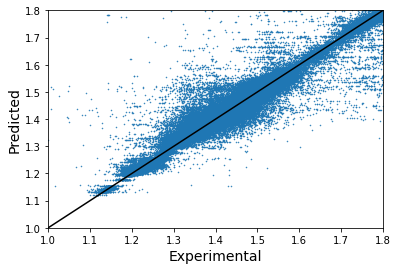

In [21]:
df = pd.DataFrame({"dists":y_test.flatten(),"pred":y_pred.flatten()})
ax = df.plot.scatter("dists","pred",s=0.25)
if mode == "bond":
  ax.set_xlim(1,1.8)
  ax.set_ylim(1,1.8)
elif mode == "angle":
  ax.set_xlim(50,140)
  ax.set_ylim(50,140)
ax.plot([0,200],[0,200],color="black")
ax.set_xlabel("Experimental",fontsize=14)
ax.set_ylabel("Predicted",fontsize=14)

<AxesSubplot:ylabel='Count'>

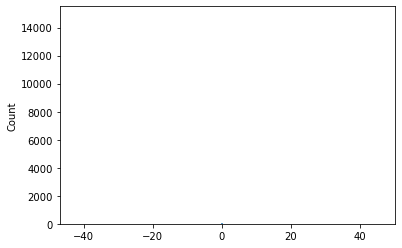

In [96]:
from sklearn.metrics import mean_squared_error
import seaborn as sns
residuals = y_test-y_pred
sns.histplot(residuals)

In [97]:
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("RMSE:",rmse)

RMSE: 0.437569434774106


## Predict some single molecules